# SpikeInterface 

### April 2024
**Author:** Rahim Hashim (rh2898@columbia.edu)<br>
**Adapted from:** [SpikeInterface Demo (11/23)](https://github.com/SpikeInterface/spiketutorials/blob/master/Official_Tutorial_SI_0.99_Nov23/SpikeInterface_Tutorial.ipynb)
***

# Table of contents

* [0. Setup](#setup)
* [1. Reading recordings folder](#read_recordings)
* [2. Extract Recordings](#extract_recordings)
* [3. Saving and loading SpikeInterface objects](#save-load)
* [4. Spike sorting](#spike-sorting)
* [5. Extracting waveforms](#waveforms)
* [6. Postprocessing](#postprocessing)
* [7. Validation and curation](#curation)
* [8. Viewers](#viewers)
* [9. Spike sorting comparison](#comparison)
* [10. Exporters](#exporters)

***
## 0. Setup  <a class="anchor" id="setup"></a>
Follow the [Official Installation Instructions](https://spikeinterface.readthedocs.io/en/0.100.1/installation.html) to install `spikeinterface` on your computer. Make sure you contain this project in a [fresh Anaconda environment](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html). From there, you can import all the following libraries without issue.

In [6]:
# default imports
import os
import re
import sys
import time
import argparse
import numpy as np
import datetime as datetime
from pathlib import Path
from pprint import pprint
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.simplefilter("ignore")
# spikeinterface imports
import spikeinterface.full as si
print(f"SpikeInterface version: {si.__version__}")
# %matplotlib widget
%matplotlib inline

SpikeInterface version: 0.100.4


***
## 1. Reading Recordings Folder <a class="anchor" id="read_recordings"></a>

Set `root` to where your recordings are. The `sglx_folder` should be the path of the folder that is generated from a completed recording session (i.e. gandalf_20240112_g0), which includes an imec folder for each probe during that recording.

In [2]:
root = 'D:'
monkey = 'gandalf'
date = '20240115'
sglx_folder = os.path.join(root, f'{monkey}_{date}_g0')
imec_folder_dict = defaultdict(str)
print(f'SpikeGLX folder: {sglx_folder}')
# print all folders that have imec<int> in them
for root, dirs, files in os.walk(sglx_folder):
	for dir in dirs:
		if re.search('imec\d', dir):
			imec_num = re.search('imec\d', dir).group()
			imec_folder_dict[imec_num] = os.path.join(root, dir)
if not imec_folder_dict:
	sys.exit(f'No imec folders found in {sglx_folder}')
imec_folder_dict

SpikeGLX folder: D:gandalf_20240115_g0


defaultdict(str,
            {'imec0': 'D:gandalf_20240115_g0\\gandalf_20240115_g0_imec0',
             'imec1': 'D:gandalf_20240115_g0\\gandalf_20240115_g0_imec1',
             'imec2': 'D:gandalf_20240115_g0\\gandalf_20240115_g0_imec2',
             'imec3': 'D:gandalf_20240115_g0\\gandalf_20240115_g0_imec3'})

***
## 2. Extract Recordings <a class="anchor" id="extract_recordings"></a>
A `Recording` object extracts information about channel ids, channel locations (if present), the sampling frequency of the recording, and the extracellular traces (when prompted). It is a class for reading data saved by SpikeGLX software. See https://billkarsh.github.io/SpikeGLX/based on neo.rawio.SpikeGLXRawIO. 

This reader is folder-based. If the folder contains several streams (e.g., “imec0.ap”, “nidq” ,”imec0.lf”), then the stream has to be specified with *stream_id*.

**NOTE**: We've included the *load_sync_channel* parameter to `read_spikeglx` to load the last channel in the stream, which is typically used for synchronization, which we will utilize with TPrime later.

In [3]:
recording_dict = defaultdict(str)
for imec_id in imec_folder_dict.keys():
	print(f'Probe: {imec_id}')
	recording = si.read_spikeglx(
		sglx_folder, 
		stream_id=f'{imec_id}.ap',
		load_sync_channel=False
	)
	
	recording_dict[imec_id] = recording
	print(recording)

Probe: imec0
SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 233,450,739 samples 
                            7,781.74s (2.16 hours) - int16 dtype - 166.98 GiB
Probe: imec1
SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 233,450,817 samples 
                            7,781.74s (2.16 hours) - int16 dtype - 166.98 GiB
Probe: imec2
SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 233,451,090 samples 
                            7,781.74s (2.16 hours) - int16 dtype - 166.98 GiB
Probe: imec3
SpikeGLXRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 233,451,200 samples 
                            7,781.74s (2.16 hours) - int16 dtype - 166.98 GiB


We can peek at the traces for some of channels for each probe. The `get_traces()` function returns a TxN numpy array where N is the number of channel ids passed in (all channel ids are passed in by default) and T is the number of frames (determined by start_frame and end_frame).

Probe: imec0
  File Size: 179.29 GB
  Brain area: PMd
  Sampling frequency: 29999.821229050278
  Number of channels: 384
  Number of segments: 1
  Traces shape (0-2s): (59999, 384)
  Properties:
[   'gain_to_uV',
    'offset_to_uV',
    'channel_name',
    'contact_vector',
    'location',
    'group',
    'inter_sample_shift',
    'brain_area']


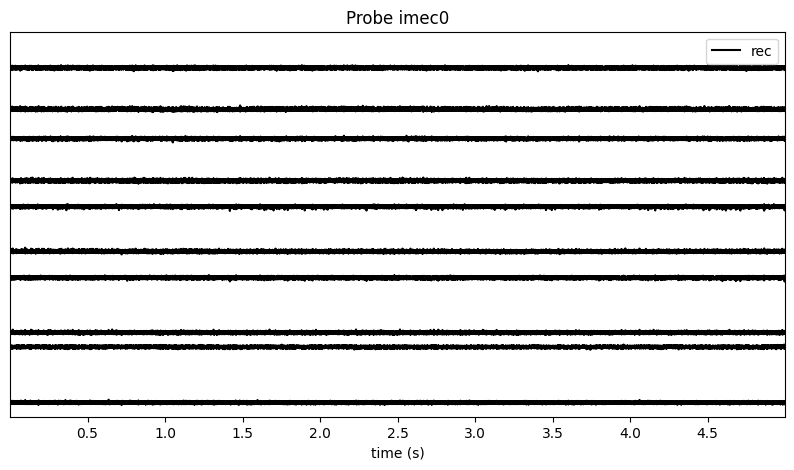

Probe: imec1
  File Size: 179.29 GB
  Brain area: HPC
  Sampling frequency: 29999.835195530726
  Number of channels: 384
  Number of segments: 1
  Traces shape (0-2s): (59999, 384)
  Properties:
[   'gain_to_uV',
    'offset_to_uV',
    'channel_name',
    'contact_vector',
    'location',
    'group',
    'inter_sample_shift',
    'brain_area']


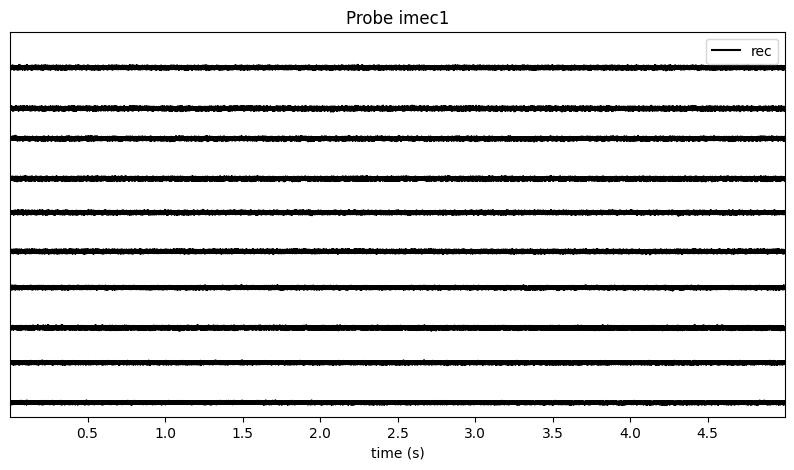

Probe: imec2
  File Size: 179.29 GB
  Brain area: DLPFCd
  Sampling frequency: 29999.858659217876
  Number of channels: 384
  Number of segments: 1
  Traces shape (0-2s): (59999, 384)
  Properties:
[   'gain_to_uV',
    'offset_to_uV',
    'channel_name',
    'contact_vector',
    'location',
    'group',
    'inter_sample_shift',
    'brain_area']


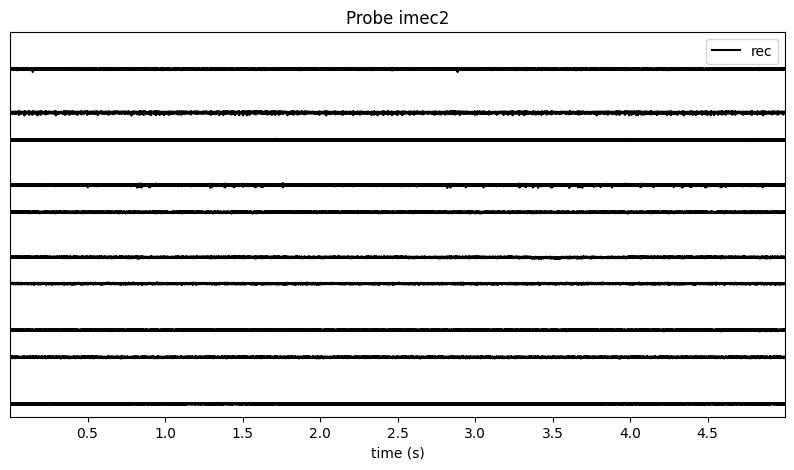

Probe: imec3
  File Size: 179.29 GB
  Brain area: DLPFCv
  Sampling frequency: 29999.887709497205
  Number of channels: 384
  Number of segments: 1
  Traces shape (0-2s): (59999, 384)
  Properties:
[   'gain_to_uV',
    'offset_to_uV',
    'channel_name',
    'contact_vector',
    'location',
    'group',
    'inter_sample_shift',
    'brain_area']


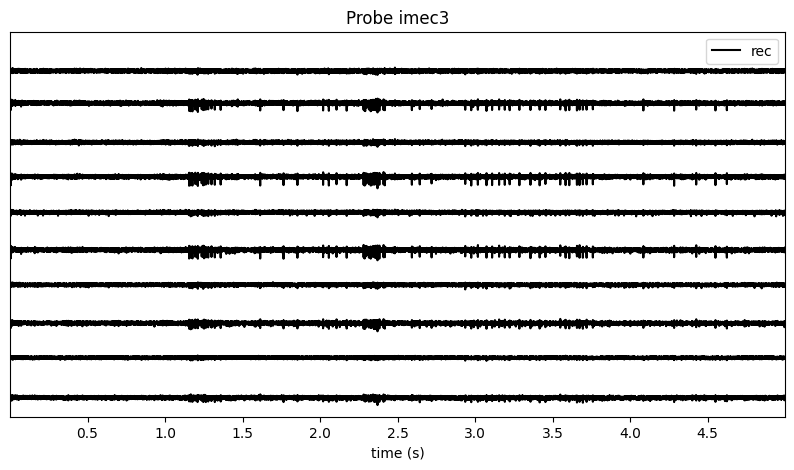

In [4]:
recording_brain_areas = {
	'imec0': 'PMd',
	'imec1': 'HPC',
	'imec2': 'DLPFCd',
	'imec3': 'DLPFCv',
}

for probe in recording_dict.keys():
	print(f'Probe: {probe}')
	recording = recording_dict[probe]
	brain_area = recording_brain_areas[probe]
	fs = recording.get_sampling_frequency()
	num_chan = recording.get_num_channels()
	num_seg = recording.get_num_segments()
	trace_snippet = recording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))
	# convert bytes to GB
	size = recording.get_total_memory_size()
	size_gb = round(size / 1e9, 2)
	print(f'  File Size: {size_gb} GB')
	print(f'  Brain area: {brain_area}')
	print(f'  Sampling frequency: {fs}')
	print(f'  Number of channels: {num_chan}')
	print(f'  Number of segments: {num_seg}')
	print(f'  Traces shape (0-2s): {trace_snippet.shape}')
	brain_area_list = [brain_area]*(num_chan-1) + ['sync'] 
	recording.set_property(key='brain_area', values=brain_area_list)
	print(f'  Properties:')
	pprint(list(recording.get_property_keys()), indent=4)
	f, ax = plt.subplots(1, 1, figsize=(10, 5))
	w_ts = si.plot_traces(recording_dict[probe],
											 ax=ax, 
											 time_range=(0, 5), 
											 channel_ids=recording.channel_ids[:10],
											 mode='line',
											 )
	# add y-axis labels for each channel
	ax.set_yticks(np.arange(10), recording.channel_ids[:10])
	ax.set_title(f'Probe {probe}')
	plt.show()
	# new recording information saved
	recording_dict[probe] = recording

***
## Probe Inspection
Before moving on with the analysis, we have to load the probe information. For this we will use the [ProbeInterface](https://probeinterface.readthedocs.io/en/main/index.html) package. 

ProbeInterface allows to easily create, manipulate, and visualize neural probes. Moreover, it comes with a wide range of IO functions to import and export existing formats. Finally, we have created a public library of commercial probes (https://github.com/SpikeInterface/probeinterface_library) that can be retrieved with a single line of code.

Let's import `probeinterface`, download the probe and plot it!

imec0:  Probe - 384ch - 1shanks
imec1:  Probe - 384ch - 1shanks
imec2:  Probe - 384ch - 1shanks
imec3:  Probe - 384ch - 1shanks


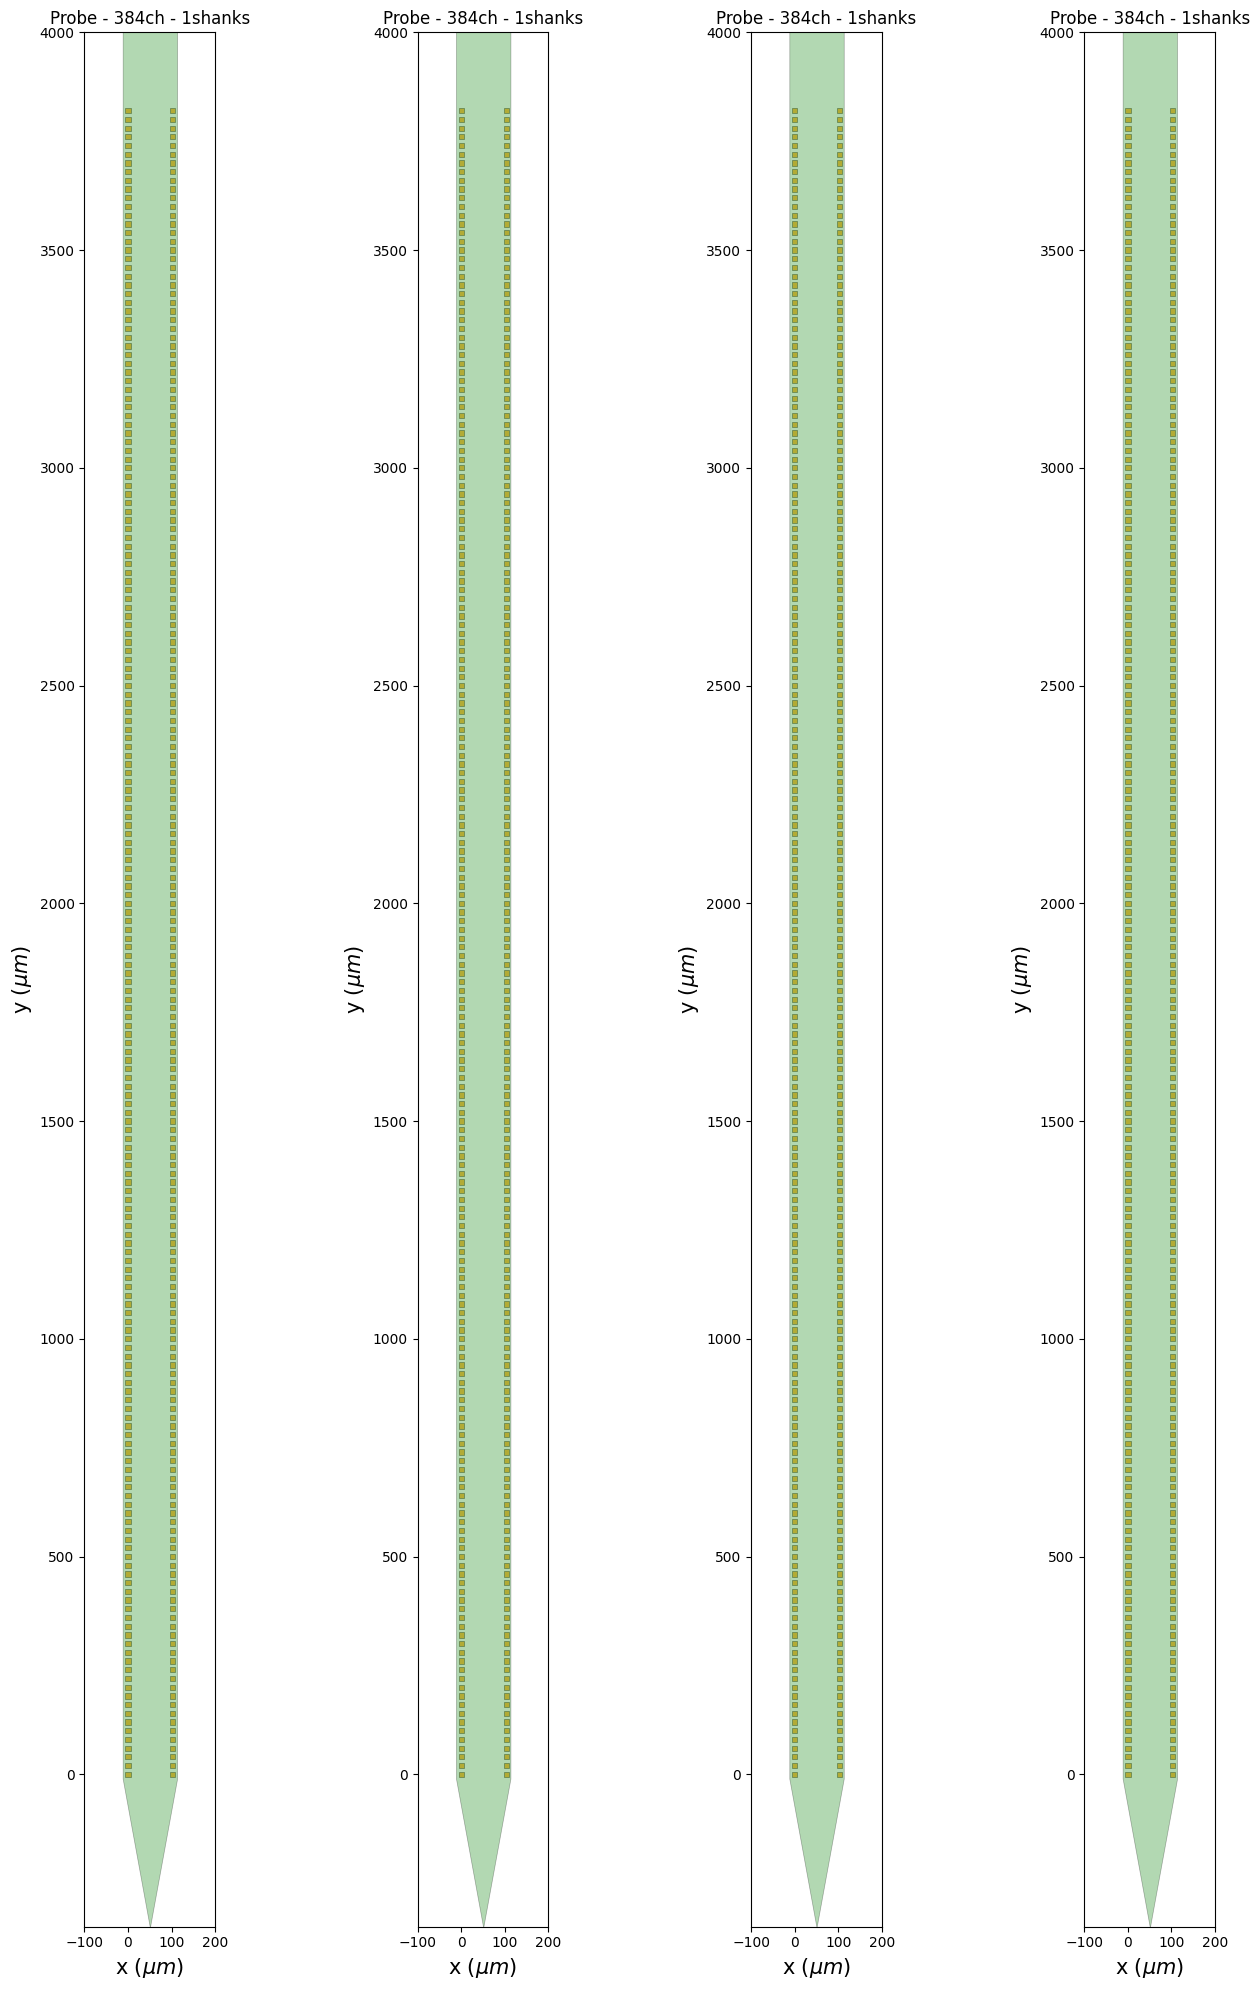

In [5]:
import probeinterface as pi
from probeinterface.plotting import plot_probe

# get first value from recording_dict
fig, ax = plt.subplots(1, len(recording_dict.keys()), figsize=(14, 20))
for idx, imec in enumerate(recording_dict.keys()):
	recording = recording_dict[imec]
	probe = recording.get_probe()
	print(f'{imec}:  {probe}')
	_ = plot_probe(probe, ax=ax[idx])
	ax[idx].set_xlim(-100, 200)
	ax[idx].set_ylim(-350, 4000)
fig.tight_layout()
plt.show()

***
## Sorters
See the available and installed sorters. For kilosort4, make sure you run `!pip install kilosort` prior to setting it.

In [7]:
print("Available sorters", si.available_sorters())
print("Installed sorters", si.installed_sorters())

if 'kilosort4' not in si.installed_sorters():
	import subprocess
	print("Installing kilosort4")
	subprocess.run(['pip install kilosort==4.0'], shell=True)
	print("Installed sorters", si.installed_sorters())
else:
	print("Kilosort4 already installed")


Available sorters ['combinato', 'hdsort', 'herdingspikes', 'ironclust', 'kilosort', 'kilosort2', 'kilosort2_5', 'kilosort3', 'kilosort4', 'klusta', 'mountainsort4', 'mountainsort5', 'pykilosort', 'spykingcircus', 'spykingcircus2', 'tridesclous', 'tridesclous2', 'waveclus', 'waveclus_snippets', 'yass']
Installed sorters ['kilosort4', 'spykingcircus2', 'tridesclous2']


In [6]:
sorter_name = 'kilosort4'
print(f"Default Paramteres for {sorter_name}")
pprint(si.get_default_sorter_params(sorter_name), indent=2)

Default Paramteres for kilosort4
{ 'Th_learned': 8,
  'Th_single_ch': 6,
  'Th_universal': 9,
  'acg_threshold': 0.2,
  'artifact_threshold': None,
  'batch_size': 60000,
  'binning_depth': 5,
  'ccg_threshold': 0.25,
  'cluster_downsampling': 20,
  'cluster_pcs': 64,
  'dmin': None,
  'dminx': None,
  'do_CAR': True,
  'do_correction': True,
  'duplicate_spike_bins': 15,
  'invert_sign': False,
  'keep_good_only': False,
  'min_template_size': 10,
  'n_pcs': 6,
  'n_templates': 6,
  'nblocks': 1,
  'nearest_chans': 10,
  'nearest_templates': 100,
  'nskip': 25,
  'nt': 61,
  'nt0min': None,
  'save_extra_kwargs': False,
  'scaleproc': None,
  'sig_interp': 20,
  'skip_kilosort_preprocessing': False,
  'template_sizes': 5,
  'templates_from_data': True,
  'whitening_range': 32}


***
## Preprocess Recordings

Now that the probe information is loaded we can do some preprocessing using `preprocessing` module.

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. 

For this notebook, let's filter the recordings and apply common median reference (CMR). All preprocessing modules return new `Recording` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

More documention on this section here: https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing.html.

We will be running the following:
1. **highpass_filter:** Perform highpass filtering.
2. **common_reference:** Remove the noise is to re-reference traces. Multiple options 
	* *reference:* using “median” or “average” (average is faster, but median is less sensitive to outliers)
	* *operator:* using “global” / “local” / “single” references
3. **phase_shift:** This apply a phase shift to a recording to cancel the small sampling delay across for some recording system.

This recreates a lot of the [SpikeGLX CatGT](https://spikeinterface.readthedocs.io/en/latest/modules/preprocessing.html#ibl-destripe) processes in the way International Brain Lab standardized.

In [7]:
def preprocess_recordings(
		recording_dict,
		highpass_filter=False, 
		common_reference_avg=False, 
		phase_shift=False, 
		find_bad_channels=False, 
		highpass_spatial_filter=False,
		save_preprocessed=False
	):
	'''
	Preprocesses recordings in a dictionary of recordings.

	Parameters:
	-----------
	recording_dict: dict
		Dictionary of extracted recordings.
	highpass_filter: bool
		Whether to apply a highpass filter to the recordings.
	common_reference_avg: bool
		Whether to apply a common reference averaging to the recordings.
	phase_shift: bool

	'''

	recording_preprocessed_dict = defaultdict(str)
	# find the time it takes to preprocess the recordings
	start_time = time.time()
	for idx, imec in enumerate(recording_dict.keys()): 
		print(f'Probe: {imec}')
		recording = recording_dict[imec]
		if highpass_filter:
			print(f'  Highpass filter n_channel_pad: 60')
			recording = highpass_filter(recording=recording, n_channel_pad=60)
		else:
			print(f'  Skipping highpass filter')
		if common_reference_avg:
			print(f'  Common reference averaging: global median')
			recording = si.common_reference(recording, reference="global", operator="median")
		else:
			print(f'  Skipping common reference')
		if phase_shift:
			print(f'  Computing phase shift')
			recording = si.phase_shift(recording)
		else:
			print(f'  Skipping phase shift')
		if find_bad_channels:
			print(f'  Detecting bad channels') 
			bad_channel_ids, channel_labels = si.detect_bad_channels(recording=recording)
			print(f'    Bad channels: {bad_channel_ids}')
			recording = si.interpolate_bad_channels(recording=recording, bad_channel_ids=bad_channel_ids)
		else:
			print(f'  Skipping bad channel detection')
		# this computes and saves the recording after applying the preprocessing chain
		if save_preprocessed:
			print(f'  Saving preprocessed recording')
			recording_preprocessed = recording.save(folder='clean_trace', format="binary")
			recording = recording_preprocessed
		recording_dict[imec] = recording
	print(f'  Preprocessing done')
	# calculate elapsed time in minutes
	total_time = round((time.time() - start_time) / 60, 2)
	print(f'Total time elapsed: {total_time} min')
	return recording_dict

recording_preprocessed_dict = preprocess_recordings(
	recording_dict, 
	highpass_filter=False, 
	common_reference_avg=False, 
	phase_shift=True, 
	find_bad_channels=True, 
	save_preprocessed=False
)

Probe: imec0
  Skipping highpass filter
  Skipping common reference
  Computing phase shift
  Detecting bad channels
    Bad channels: ['imec0.ap#AP334']
Probe: imec1
  Skipping highpass filter
  Skipping common reference
  Computing phase shift
  Detecting bad channels
    Bad channels: ['imec1.ap#AP191']
Probe: imec2
  Skipping highpass filter
  Skipping common reference
  Computing phase shift
  Detecting bad channels
    Bad channels: ['imec2.ap#AP191']
Probe: imec3
  Skipping highpass filter
  Skipping common reference
  Computing phase shift
  Detecting bad channels
    Bad channels: ['imec3.ap#AP156']
  Preprocessing done
Total time elapsed: 3.99


In [10]:
def sort_recordings(recording_dict, sorter_name='kilosort4'):
	sorted_dict = defaultdict(str)
	start_time = time.time()
	for idx, imec in enumerate(recording_dict.keys()):
		probe_start_time = time.time()
		print(f'Probe: {imec}')
		recording = recording_dict[imec]
		print(f'  Running {sorter_name}')

		sorted_folder = os.path.join(imec_folder_dict[imec], f'{imec}_ks_output')
		sorted_recording = si.run_sorter(
			sorter_name=sorter_name, 
			recording=recording,
			output_folder=sorted_folder,
			verbose=True)
		print(f'  {sorted_recording}')
		print(f'  Number of clusters: {len(sorted_recording.get_unit_ids())} units')
		sorted_dict[imec] = sorted_recording
		w_rs = si.plot_rasters(sorted_recording)
		plt.show()
		probe_end_time = round((time.time() - start_time) / 60, 2)
		print(f'  Time elapsed: {probe_start_time} min')
	total_time = round((time.time() - start_time) / 60, 2)
	print(f'Total time elapsed: {total_time} min')
	return sorted_dict

sorted_recording_dict = sort_recordings(
	recording_preprocessed_dict, 
	sorter_name='kilosort4'
)

Probe: imec0
  Running kilosort4


Exception: The sorter kilosort4 is not installed.Please install it with:  

To use Kilosort4 run:

        >>> pip install kilosort==4.0

    More information on Kilosort4 at:
        https://github.com/MouseLand/Kilosort
     

# 5. Extracting waveforms <a class="anchor" id="waveforms"></a>

The core of postprocessing spike sorting results revolves around extracting waveforms from paired recording-sorting objects.

In the SI API, waveforms are extracted using the `WaveformExtractor` class in the `core` module.

The `WaveformExtractor` object has convenient functions to retrieve waveforms and templates. By default, the `WaveformExtractor` extracts waveforms on a random subset of 500 spikes. To extract waveforms on all spikes, we could use the `max_spikes_per_unit` argument, but that is more than we can visualize.

To extract the waveforms, we can run:

In [2]:
def extract_waveforms(recording_dict, sorted_recording_dict):
	waveform_dict = defaultdict(str)
	for idx, imec in enumerate(recording_dict.keys()):
		print(f'Probe: {imec}')
		recording = recording_dict[imec]
		sorted_recording = sorted_recording_dict[imec]
		print(f'  Extracting waveforms')
		waveform_folder = os.path.join(sorted_output_folder, 'waveforms')
		we = si.extract_waveforms(
			recording, 
			sorted_recording, 
			folder=waveform_folder, 
			sparse=False, 
			overwrite=True
			)
		sorted_output_folder = os.path.join(imec_folder_dict[imec], f'phy_{imec}_ks4') 
		print(f'  Saving sorted recording to {sorted_output_folder}')
		sorted_recording.save(folder=sorted_output_folder)
		waveforms0 = we.get_waveforms(unit_id=0)
		print(f"Waveforms shape: {waveforms0.shape}")
		template0 = we.get_template(unit_id=0)
		print(f"Template shape: {template0.shape}")
		all_templates = we.get_all_templates()
		print(f"All templates shape: {all_templates.shape}")
		print(we)
		waveform_dict[imec] = we
		si.plot_unit_template(we)
	return waveform_dict

sorted_recording_dict = extract_waveforms(
	sorted_recording_dict, 
	sorter_name='kilosort4'
)

NameError: name 'recording_preprocessed_dict' is not defined

## Sparsity

Especially when working with silicon high-density probes, or when our probe has multiple groups (e.g. multi-shank, tetrodes), we don't care about waveform/templates on all channels.
In order to find a subset of channels for each unit, we can use the `compute_sparsity()` which give an object of sparsity per unit.

In [84]:
sparsity = si.compute_sparsity(we, method='radius', radius_um=100.0)
sparsity

ChannelSparsity - units: 170 - channels: 47 - density, P(x=1): 0.26

In [85]:
#  check the sparsity for some units
for unit_id in sorting.unit_ids[::30]:
	print(unit_id, list(sparsity.unit_id_to_channel_ids[unit_id]))

0 ['CH9', 'CH16', 'CH18', 'CH21', 'CH22', 'CH24', 'CH26', 'CH31']
30 ['CH10', 'CH12', 'CH17', 'CH23', 'CH29', 'CH33', 'CH34', 'CH37', 'CH41', 'CH46', 'CH49', 'CH51', 'CH54']
61 ['CH36', 'CH38', 'CH39', 'CH43', 'CH47', 'CH52', 'CH55', 'CH56']
91 ['CH10', 'CH33', 'CH34', 'CH35', 'CH37', 'CH41', 'CH44', 'CH46', 'CH48', 'CH49', 'CH50', 'CH51', 'CH53']
121 ['CH10', 'CH11', 'CH12', 'CH13', 'CH17', 'CH19', 'CH23', 'CH25', 'CH29', 'CH34', 'CH37', 'CH46', 'CH54']
151 ['CH10', 'CH33', 'CH34', 'CH35', 'CH37', 'CH41', 'CH44', 'CH46', 'CH48', 'CH49', 'CH50', 'CH51', 'CH53']


In [86]:
## lets use this sparsity object to extract waveforms again

In [87]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_sparse_explicit", 
													sparsity=sparsity, **job_kwargs)
print(we)

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 47 channels - 170 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [88]:
# the waveforms are now sparse
for unit_id in we.unit_ids[::10]:
	waveforms = we.get_waveforms(unit_id=unit_id)
	print(unit_id, waveforms.shape)

0 (500, 90, 8)
10 (96, 90, 13)
20 (347, 90, 10)
30 (286, 90, 13)
40 (500, 90, 13)
51 (99, 90, 12)
61 (435, 90, 8)
71 (227, 90, 12)
81 (500, 90, 13)
91 (500, 90, 13)
101 (74, 90, 13)
111 (161, 90, 8)
121 (59, 90, 13)
131 (500, 90, 13)
141 (492, 90, 13)
151 (316, 90, 13)
161 (40, 90, 13)


we can also auto estimate the sparsity directly on waveforms extraction, this avoid extacting twice (one dense + one sparse)

In [89]:
we = si.extract_waveforms(recording_saved, sorting, folder=base_folder / "waveforms_sparse", 
													sparse=True, **job_kwargs)
print(we)

extract waveforms shared_memory multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

extract waveforms memmap multi buffer:   0%|          | 0/300 [00:00<?, ?it/s]

WaveformExtractor: 47 channels - 170 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [90]:
# and we can acces the sparsity as an attributes of the object
print(we.sparsity)

ChannelSparsity - units: 170 - channels: 47 - density, P(x=1): 0.26


Most of the plotting and exporting functions accept `sparsity` as an argument, but they will also automatically display sparse waveforms if the `WaveformExtractor` is sparse.

In [91]:
%matplotlib widget
si.plot_unit_templates(we, backend="ipywidgets")

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

# 6. Postprocessing <a class="anchor" id="postprocessing"></a>

Postprocessing spike sorting results ranges from computing additional information, such as spike amplitudes and Principal Component Analisys (PCA) scores, to computing features of the extracellular waveforms, similarity between templates and crosscorrelograms. All of this is possible with the `postprocessing` module.


See also : https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html

### PCA scores

PCA scores can be easily computed with the `compute_principal_components()` function. Similarly to the `extract_waveforms`, the function returns an object of type `WaveformPrincipalComponent` that allows to retrieve all pc scores on demand.

In [92]:
pc = si.compute_principal_components(we, n_components=3, load_if_exists=False, **job_kwargs)

Fitting PCA:   0%|          | 0/170 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/170 [00:00<?, ?it/s]

In [93]:
pc0 = pc.get_projections(unit_id=0)
print(f"PC scores shape: {pc0.shape}")
all_labels, all_pcs = pc.get_all_projections()
print(f"All PC scores shape: {all_pcs.shape}")

PC scores shape: (500, 3, 47)
All PC scores shape: (57016, 3, 47)


For pc scores of a single unit, the dimension is (num_spikes, num_components, num_channels). 

## WaveformExtensions

When we compute PCA (or use other postprocessing functions), the computed information is added to the waveform folder. The functions act as `WaveformExtensions`:

For more details see this https://spikeinterface.readthedocs.io/en/latest/modules/postprocessing.html#waveformextractor-extensions


In [94]:
we.get_available_extension_names()

['principal_components']

Each `WaveformExtension` is an object that allows us to retrieve the data:

In [95]:
pc = we.load_extension("principal_components")
print(pc)

WaveformPrincipalComponent: 47 channels - 1 segments
  mode: by_channel_local n_components: 3


In [96]:
all_labels, all_pcs = pc.get_data()
print(all_pcs.shape)

(57016, 3, 47)


### Spike amplitudes

Spike amplitudes can be computed with the `get_spike_amplitudes` function.

In [97]:
amplitudes = si.compute_spike_amplitudes(we, outputs="by_unit", load_if_exists=True, **job_kwargs)

extract amplitudes:   0%|          | 0/300 [00:00<?, ?it/s]

By default, all amplitudes are concatenated in one array with all amplitudes form all spikes. With the `output="by_unit"` argument, instead, a dictionary is returned:

In [98]:
amplitudes[0][15]

array([ -8.19    , -32.954998, -31.98    , ..., -24.765   , -34.32    ,
       -25.74    ], dtype=float32)

In [99]:
%matplotlib widget
si.plot_amplitudes(we, backend="ipywidgets")

AppLayout(children=(VBox(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='…

### Compute unit and spike locations

When using silicon probes, we can estimate the unit (or spike) location with triangulation. This can be done either with a simple center of mass or by assuming a monopolar model:

$$V_{ext}(\boldsymbol{r_{ext}}) = \frac{I_n}{4 \pi \sigma |\boldsymbol{r_{ext}} - \boldsymbol{r_{n}}|}$$

where $\boldsymbol{r_{n}}$ is the position of the neuron, and $\boldsymbol{r_{n}}$ of the electrode(s).

In [100]:
unit_locations = si.compute_unit_locations(we, method="monopolar_triangulation", load_if_exists=True)
spike_locations = si.compute_spike_locations(we, method="center_of_mass", load_if_exists=True, **job_kwargs)

localize peaks using center_of_mass:   0%|          | 0/300 [00:00<?, ?it/s]

In [101]:
%matplotlib widget
si.plot_unit_locations(we, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

In [102]:
%matplotlib widget
si.plot_spike_locations(we, max_spikes_per_unit=300, backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

### Compute correlograms

In [103]:
ccgs, bins = si.compute_correlograms(we)

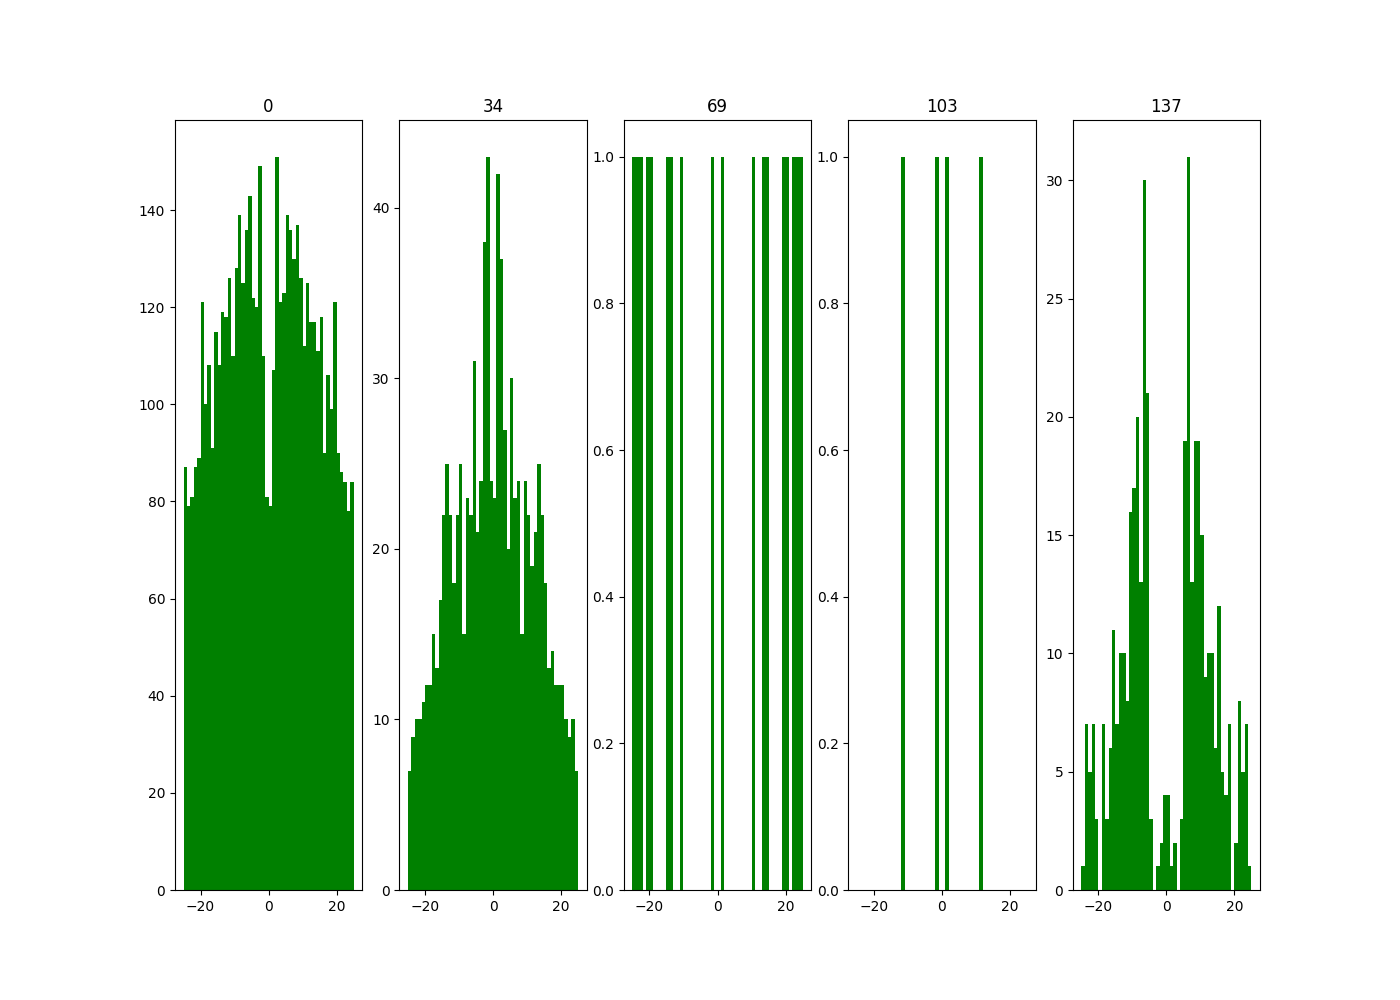

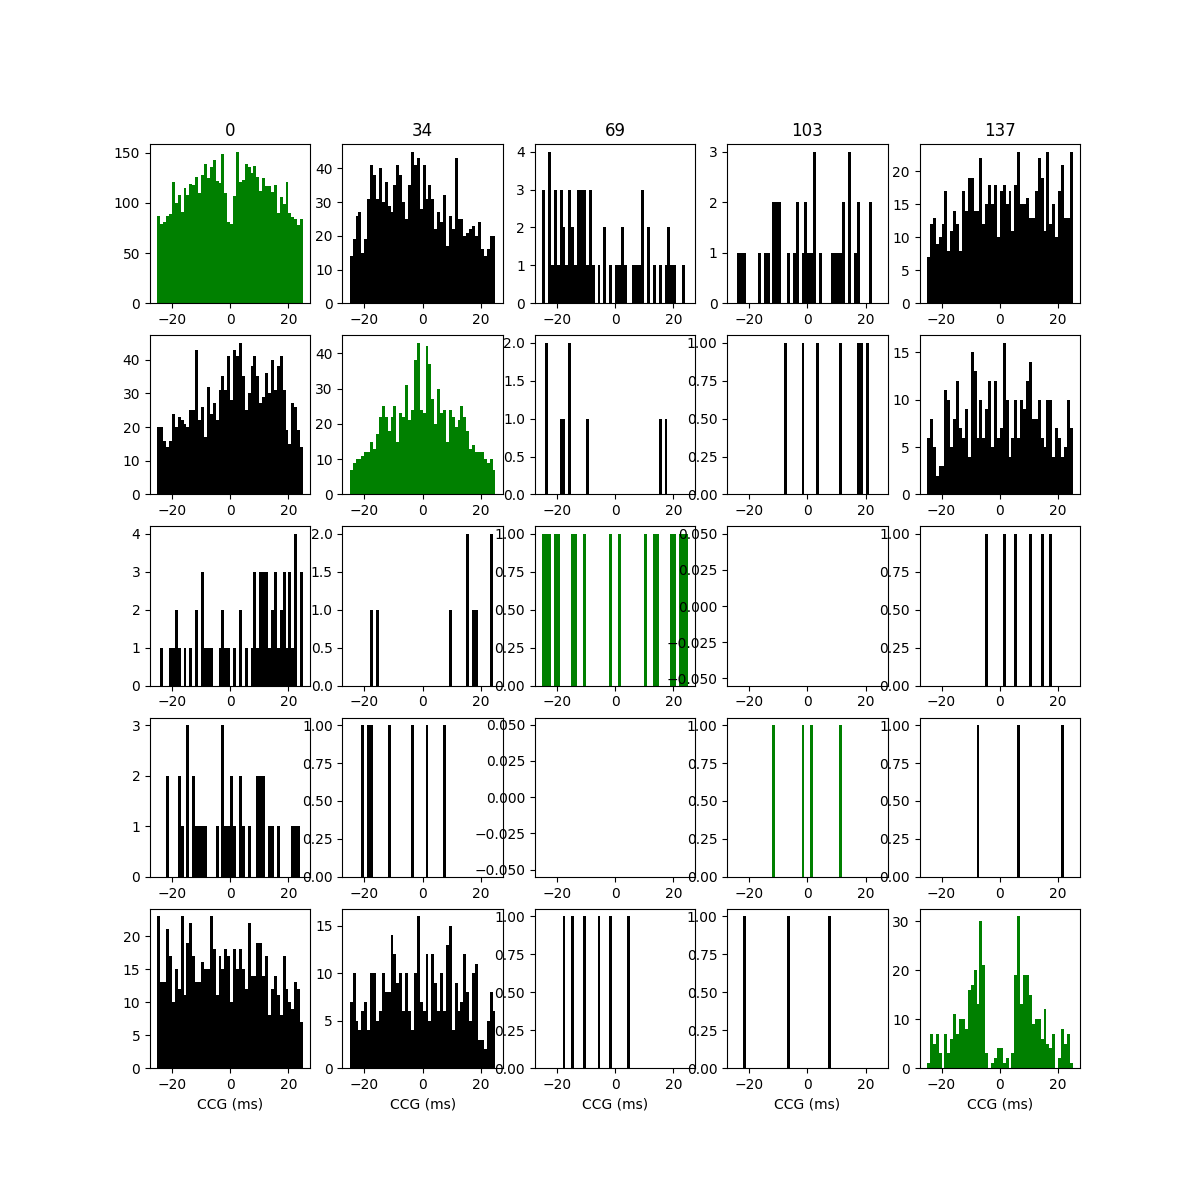

In [105]:
si.plot_autocorrelograms(we, unit_ids=sorting.unit_ids[::34], figsize=(14, 10))
si.plot_crosscorrelograms(we, unit_ids=sorting.unit_ids[::34], figsize=(12, 12))

### Compute template similarity

In [106]:
similarity = si.compute_template_similarity(we)

### Compute template metrics

Template metrics, or extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). The `postprocessing` allows one to compute several of these metrics:

In [107]:
print(si.get_template_metric_names())

['peak_to_valley', 'peak_trough_ratio', 'half_width', 'repolarization_slope', 'recovery_slope', 'num_positive_peaks', 'num_negative_peaks', 'velocity_above', 'velocity_below', 'exp_decay', 'spread']


In [108]:
template_metrics = si.compute_template_metrics(we)
display(template_metrics)

,peak_to_valley,peak_trough_ratio,half_width,repolarization_slope,recovery_slope,num_positive_peaks,num_negative_peaks
0,0.000857,-0.266235,0.00031,88887.017813,-12960.426608,2,1
1,0.000947,-0.266814,0.000297,226656.397584,-41678.958489,2,1
2,0.000797,-0.328291,0.00031,134373.509091,-20587.093939,1,1
3,0.000747,-0.285943,0.000267,295207.358725,-37865.772697,1,1
4,0.000853,-0.285516,0.000233,303555.317133,-59437.486157,1,1
...,...,...,...,...,...,...,...
166,0.000877,-0.249747,0.000277,223526.094652,-30710.650084,2,1
167,0.001093,-0.184666,0.000263,96652.676067,-12574.938262,1,1
168,0.001063,-0.302432,0.000373,68649.42576,-13542.827585,2,1
169,0.00084,-0.335455,0.000323,125585.635503,-22126.73055,2,1


In [110]:
si.plot_template_metrics(we, include_metrics=["peak_to_valley", "half_width"], 
												 backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these template metrics, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

# 7. Quality metrics and curation <a class="anchor" id="curation"></a>

The `qualitymetrics` module also provides several functions to compute qualitity metrics to validate the spike sorting results.

See also this : https://spikeinterface.readthedocs.io/en/latest/modules/qualitymetrics.html

Let's see what metrics are available:

In [111]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [112]:
qm_params = si.get_default_qm_params()
qm_params

{'presence_ratio': {'bin_duration_s': 60, 'mean_fr_ratio_thresh': 0.0},
 'snr': {'peak_sign': 'neg',
  'peak_mode': 'extremum',
  'random_chunk_kwargs_dict': None},
 'isi_violation': {'isi_threshold_ms': 1.5, 'min_isi_ms': 0},
 'rp_violation': {'refractory_period_ms': 1.0, 'censored_period_ms': 0.0},
 'sliding_rp_violation': {'min_spikes': 0,
  'bin_size_ms': 0.25,
  'window_size_s': 1,
  'exclude_ref_period_below_ms': 0.5,
  'max_ref_period_ms': 10,
  'contamination_values': None},
 'synchrony': {'synchrony_sizes': (2, 4, 8)},
 'firing_range': {'bin_size_s': 5, 'percentiles': (5, 95)},
 'amplitude_cv': {'average_num_spikes_per_bin': 50,
  'percentiles': (5, 95),
  'min_num_bins': 10,
  'amplitude_extension': 'spike_amplitudes'},
 'amplitude_cutoff': {'peak_sign': 'neg',
  'num_histogram_bins': 100,
  'histogram_smoothing_value': 3,
  'amplitudes_bins_min_ratio': 5},
 'amplitude_median': {'peak_sign': 'neg'},
 'drift': {'interval_s': 60,
  'min_spikes_per_interval': 100,
  'direction':

In [113]:
qm_params['isi_violation']['isi_threshold_ms'] = 1.1

In [114]:
metric_names = si.get_quality_metric_list()
# metric_names = si.get_quality_metric_list() + si.get_quality_pca_metric_list()
qm = si.compute_quality_metrics(we, metric_names=metric_names, verbose=True,  qm_params=qm_params, **job_kwargs)


Computing num_spikes
Computing firing_rate
Computing presence_ratio
Computing snr
Computing isi_violation
Computing rp_violation
Computing sliding_rp_violation
Computing amplitude_cutoff
Computing amplitude_median
Computing amplitude_cv
Computing synchrony
Computing firing_range
Computing drift


In [115]:
display(qm)

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,amplitude_median,amplitude_cv_median,amplitude_cv_range,sync_spike_2,sync_spike_4,sync_spike_8,firing_range,drift_ptp,drift_std,drift_mad
0,3467.0,11.556667,1.0,6.699185,0.907572,80,1.000000,81,NaN,0.000365,32.174999,0.371593,0.299797,0.030862,0.0,0.0,5.63,0.301125,0.110323,0.094155
1,945.0,3.150000,1.0,15.370731,0.152699,1,0.185099,1,NaN,0.009748,94.574997,0.178557,0.126878,0.024339,0.0,0.0,3.01,0.615780,0.218826,0.162426
2,805.0,2.683333,1.0,8.187921,0.631289,3,0.727769,2,NaN,0.003454,50.309998,0.304148,0.229177,0.034783,0.0,0.0,3.01,1.708486,0.613580,0.493461
3,1042.0,3.473333,1.0,16.009048,0.753554,6,1.000000,6,NaN,0.001854,81.899994,0.264475,0.105284,0.051823,0.0,0.0,2.22,0.938872,0.329965,0.208018
4,3051.0,10.170000,1.0,20.417950,0.512722,35,1.000000,33,NaN,0.000446,119.339996,0.133316,0.064901,0.035398,0.0,0.0,4.60,0.528079,0.190110,0.156396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,478.0,1.593333,1.0,13.007952,0.596819,1,1.000000,1,NaN,NaN,79.364998,NaN,NaN,0.039749,0.0,0.0,1.60,NaN,NaN,NaN
167,743.0,2.476667,1.0,8.902170,0.000000,0,0.000000,0,0.195,0.000647,53.624996,0.236704,0.092628,0.029610,0.0,0.0,1.62,0.740657,0.285873,0.264649
168,1179.0,3.930000,1.0,5.772798,0.196201,2,0.246105,2,NaN,0.001396,35.489998,0.396619,0.173722,0.036472,0.0,0.0,5.42,0.859374,0.292842,0.193800
169,1061.0,3.536667,1.0,8.605642,1.090210,9,1.000000,9,NaN,0.001560,46.994999,0.274625,0.210853,0.086711,0.0,0.0,2.62,1.301045,0.526499,0.474456


In [116]:
si.plot_quality_metrics(we, include_metrics=["amplitude_cutoff", "presence_ratio", "isi_violations_ratio", "snr"], 
												backend="ipywidgets")

AppLayout(children=(UnitSelector(children=(Label(value='Units', layout=Layout(justify_content='center')), Sele…

For more information about these waveform features, we refer to the [SpikeInterface documentation](https://spikeinterface.readthedocs.io/en/latest/module_qualitymetrics.html) and to this excellent [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

## Automatic curation based on quality metrics

A viable option to curate (or at least pre-curate) a spike sorting output is to filter units based on quality metrics. As we have already computed quality metrics a few lines above, we can simply filter the `qm` dataframe based on some thresholds.

Here, we'll only keep units with an ISI violation threshold and amplitude cutoff below a user-defined threshold:

In [117]:
isi_viol_thresh = 0.5
amp_cutoff_thresh = 0.1

A straightforward way to filter a pandas dataframe is via the `query`.
We first define our query (make sure the names match the column names of the dataframe):

In [118]:
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh}"
print(our_query)

amplitude_cutoff < 0.1 & isi_violations_ratio < 0.5


and then we can use the query to select units:

In [119]:
keep_units = qm.query(our_query)
keep_unit_ids = keep_units.index.values
keep_unit_ids

array([  1,   8,  14,  15,  16,  42,  62,  63,  73,  76,  81,  92, 102,
       107, 118, 120, 123, 125, 130, 133, 138, 140, 147, 149, 150, 154,
       155, 159, 162, 164, 165, 167, 168])

In [120]:
sorting_auto_KS25 = sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto_KS25.get_unit_ids())}")

Number of units before curation: 170
Number of units after curation: 33


We can also save all the waveforms and post-processed data for curated units in a separate folder:

In [121]:
we_curated = we.select_units(keep_unit_ids, new_folder=base_folder / "waveforms_curated")

In [122]:
print(we_curated)

WaveformExtractor: 47 channels - 33 units - 1 segments
  before:30 after:60 n_per_units:500 - sparse


In [123]:
%matplotlib widget
si.plot_unit_templates(we_curated, backend='ipywidgets')

AppLayout(children=(HBox(children=(Checkbox(value=False, description='same axis'), Checkbox(value=True, descri…

In [124]:
we_curated.get_available_extension_names()

['template_metrics',
 'similarity',
 'principal_components',
 'spike_amplitudes',
 'correlograms',
 'spike_locations',
 'unit_locations',
 'quality_metrics']

# 8. Viewers <a class="anchor" id="viewers"></a>


### SpikeInterface GUI

A QT-based GUI built on top of SpikeInterface objects.

Developed by Samuel Garcia, CRNL, Lyon.

In [135]:
# !sigui {base_folder}/waveforms_sparse

### Sorting Summary - SortingView

The `sortingview` backend requires an additional step to configure the transfer of the data to be plotted to the cloud. 

See documentation [here](https://spikeinterface.readthedocs.io/en/latest/module_widgets.html).

Developed by Jeremy Magland and Jeff Soules, Flatiron Institute, NYC

In [127]:
w = si.plot_sorting_summary(we_curated, backend="sortingview")

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://2a2cc53d21a7677c130fda6436c5839184f3e974

`sortingview` can also be used for manual curation and labeling of units!

In [136]:
# w = si.plot_sorting_summary(we_curated, backend="sortingview", curation=True)

https://figurl.org/f?v=gs://figurl/spikesortingview-10&d=sha1://61648243fcfd694dd6b179bc85626db03675a36f

You can apply the `sortingview` curation file with:

`sorting_manual_curated = si.apply_sortingview_curation(we_curated.sorting, uri_or_json="curation.json")`

# 9. Spike sorting comparison <a class="anchor" id="comparison"></a>

Can we combine the output of multiple sorters to curate the spike sorting output?

To answer this question we can use the `comparison` module.
We first compare and match the output spike trains of the different sorters, and we can then extract a new `Sorting` with only the units in agreement.

In [125]:
sorting_KS25 = si.read_sorter_folder(base_folder/"results_KS25")
sorting_KS2 = si.read_sorter_folder(base_folder/"results_KS2")

### Compare two sorters

In [126]:
comp_KS2_KS25 = si.compare_two_sorters(sorting_KS2, sorting_KS25, 'KS2', 'KS25')

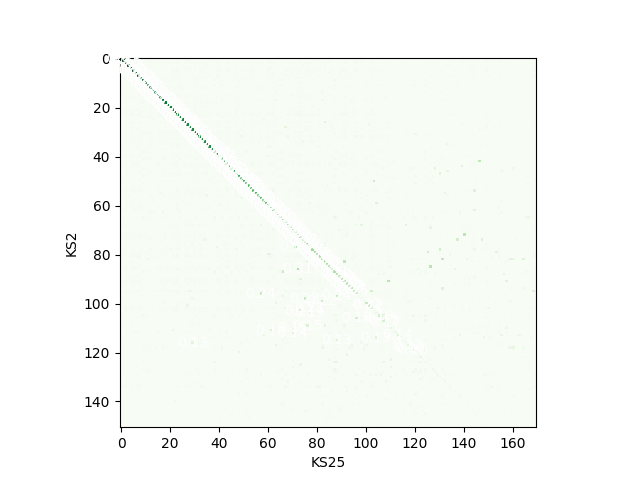

In [127]:
si.plot_agreement_matrix(comp_KS2_KS25, unit_ticks=False)

In [128]:
comp_KS2_KS25auto = si.compare_two_sorters(sorting_KS2, sorting_auto_KS25, 'KS2', 'KS25_auto')

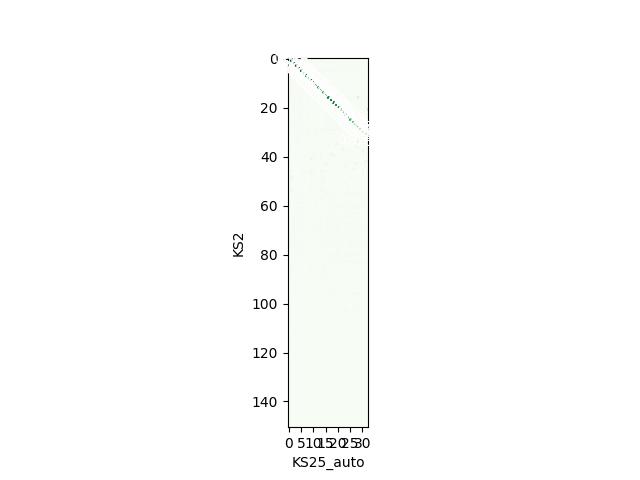

In [129]:
si.plot_agreement_matrix(comp_KS2_KS25auto, unit_ticks=False)

### Compare multiple sorters

In 2020, the spike interface team publish an article to demonstrate that sorters do not agree on the results.
See this https://elifesciences.org/articles/61834

Here is a direct illustration of the phenomenom on this dataset.

In [130]:
mcmp = si.compare_multiple_sorters([sorting_KS2, sorting_KS25], ['KS2', 'KS25'], 
																	 spiketrain_mode='union', verbose=True)

Multicomaprison step 1: pairwise comparison
  Comparing: KS2 and KS25
Multicomparison step 2: make graph
Multicomaprison step 3: clean graph
Removed 0 duplicate nodes
Multicomparison step 4: extract agreement from graph


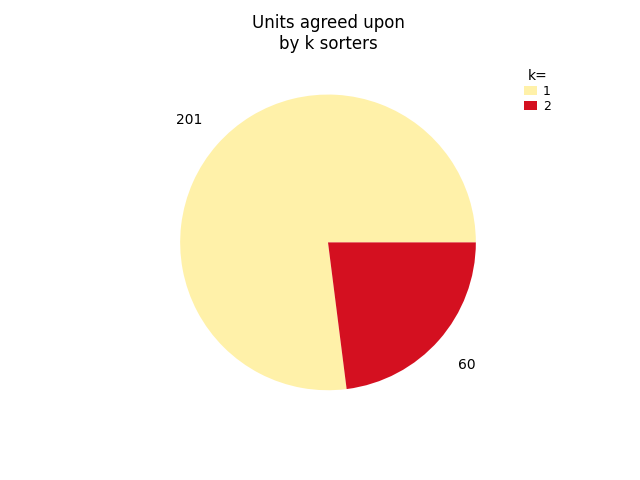

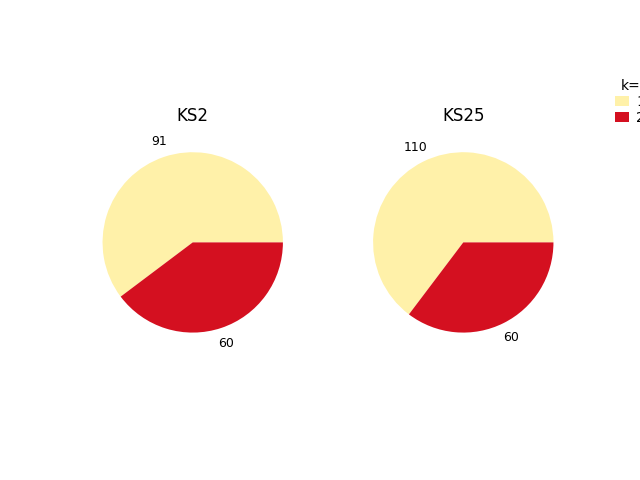

In [131]:
w = si.plot_multicomparison_agreement(mcmp)
w = si.plot_multicomparison_agreement_by_sorter(mcmp)

In [132]:
agreement_sorting = mcmp.get_agreement_sorting(minimum_agreement_count=2)
print(agreement_sorting)

AgreementSortingExtractor: 60 units - 1 segments - 30.0kHz


# 10. Exporters <a class="anchor" id="exporters"></a>

## Export to Phy for manual curation

To perform manual curation we can export the data to [Phy](https://github.com/cortex-lab/phy). 

In [133]:
si.export_to_phy(we, output_folder=base_folder / 'phy_KS25', 
								 compute_amplitudes=False, compute_pc_features=False, copy_binary=False,
								 **job_kwargs)

Run:
phy template-gui  /data_local/DataSpikeSorting/SI_tutorial_cambridgeneurotech_2023/phy_KS25/params.py


![phy](./phy.png)

After curating the results we can reload it using the `PhySortingExtractor` and exclude the units that we labeled as `noise`:

`sorting_phy_curated = si.read_phy(base_folder / 'phy_KS25/', exclude_cluster_groups=['noise'])`

## Export a report to a folder



In [ ]:
si.export_report(we, output_folder=base_folder / 'report_KS25')

### Et voilà!